In [212]:
import sys
sys.path.append('../')
import time
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from scipy.signal import convolve2d
from scipy.optimize import curve_fit
from scipy.optimize import brute
# import cv2
import torch
import json
import csv
from models import *
from functions.all_knots_functions import *
from torch.utils.data import TensorDataset, DataLoader
from torch import nn
from sklearn.model_selection import train_test_split
from torch.optim import lr_scheduler
from torch.optim.lr_scheduler import ReduceLROnPlateau
import collections
import itertools
import torch

import torch.nn.functional as F
from tqdm import trange
import pickle
from sklearn.metrics import confusion_matrix
import seaborn as sns
from torchsummary import summary
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [213]:
hyperparams = {
    'learning_rate': 1e-5,  # Control dropout rate
    'patience': 5,  # Number of epochs between learning rate decay
    'factor': 0.2,  # Multiplicative factor of learning rate decay
    'batch_size': 64
}
desired_res = (32, 32, 64)

In [214]:
foils = list(itertools.product(range(3), repeat=4))
foils = foils[:]
knots = [''.join([str(element) for element in foil]) for foil in foils]
knot_types = {
	knot: it for it, knot in enumerate(knots)
}
for i, knot in enumerate(knots):
    print(knot, ':  ', i)

0000 :   0
0001 :   1
0002 :   2
0010 :   3
0011 :   4
0012 :   5
0020 :   6
0021 :   7
0022 :   8
0100 :   9
0101 :   10
0102 :   11
0110 :   12
0111 :   13
0112 :   14
0120 :   15
0121 :   16
0122 :   17
0200 :   18
0201 :   19
0202 :   20
0210 :   21
0211 :   22
0212 :   23
0220 :   24
0221 :   25
0222 :   26
1000 :   27
1001 :   28
1002 :   29
1010 :   30
1011 :   31
1012 :   32
1020 :   33
1021 :   34
1022 :   35
1100 :   36
1101 :   37
1102 :   38
1110 :   39
1111 :   40
1112 :   41
1120 :   42
1121 :   43
1122 :   44
1200 :   45
1201 :   46
1202 :   47
1210 :   48
1211 :   49
1212 :   50
1220 :   51
1221 :   52
1222 :   53
2000 :   54
2001 :   55
2002 :   56
2010 :   57
2011 :   58
2012 :   59
2020 :   60
2021 :   61
2022 :   62
2100 :   63
2101 :   64
2102 :   65
2110 :   66
2111 :   67
2112 :   68
2120 :   69
2121 :   70
2122 :   71
2200 :   72
2201 :   73
2202 :   74
2210 :   75
2211 :   76
2212 :   77
2220 :   78
2221 :   79
2222 :   80


In [215]:



# folder = '../DATA/HOPFS_L270_5e-07_test_1s'
# folder = '../HOPFS_L270_5e-07_test_1s'
# List of folders to search for data
# folders = [
#     '../4foils_L270_0.15_50_64x64x64_v1',
#     '../4foils_L270_0.05_50_64x64x64_v1',
#     '../4foils_L270_0.25_50_64x64x64_v1'
# ]
folders = [
    '../flower2220/',

]
folders = [
    '/home/dt169/ML_knots/DATA/all_flowers10_5.4/',
]

num_classes = len(knots)
X_list = []
Y_list = []
csv.field_size_limit(10000000)

# Flag to print shape once
flag_print_shape = True

# Loop through all folders and knots
for folder in folders:
	for knot in knots:
		filename = f'{folder}/data_experiment_{knot}.csv'
		try:
			with open(filename, 'r') as file:
				reader = csv.reader(file)
				for row in reader:
					# Deserialize the JSON string back to a list
					data_list = json.loads(row[0])
					data_array = np.array(data_list)

					# Extract points and dimensions
					points_list = data_array[2:]
					Nx, Ny, Nz = data_array[1]

					if flag_print_shape:
						print(f'Shape: {Nx}, {Ny}, {Nz}')
						flag_print_shape = False

					# Rescale if necessary
					if desired_res != (Nx, Ny, Nz):
						scale_x = desired_res[0] / Nx
						scale_y = desired_res[1] / Ny
						scale_z = desired_res[2] / Nz
						points_list = np.rint(points_list * np.array([scale_x, scale_y, scale_z])).astype(int)

					# Initialize a 3D array and set points to 1
					dots_3d = np.zeros(desired_res, dtype=int)
					for x, y, z in points_list:
						try:
							dots_3d[x, y, z] = 1
						except IndexError:
							continue

					# Append to lists
					X_list.append(dots_3d)
					Y_list.append(knot_types[knot])

		except FileNotFoundError:
			print(f'File not found: {filename}')
		except json.JSONDecodeError:
			print(f'Error decoding JSON in file: {filename}')

print(f'Loaded {len(X_list)} samples.  {int(len(X_list) / len(knots))} per class')




File not found: /home/dt169/ML_knots/DATA/all_flowers10_5.4//data_experiment_0000.csv
File not found: /home/dt169/ML_knots/DATA/all_flowers10_5.4//data_experiment_0001.csv
File not found: /home/dt169/ML_knots/DATA/all_flowers10_5.4//data_experiment_0002.csv
File not found: /home/dt169/ML_knots/DATA/all_flowers10_5.4//data_experiment_0010.csv
File not found: /home/dt169/ML_knots/DATA/all_flowers10_5.4//data_experiment_0011.csv
File not found: /home/dt169/ML_knots/DATA/all_flowers10_5.4//data_experiment_0012.csv
File not found: /home/dt169/ML_knots/DATA/all_flowers10_5.4//data_experiment_0020.csv
File not found: /home/dt169/ML_knots/DATA/all_flowers10_5.4//data_experiment_0021.csv
Shape: 32, 32, 64
File not found: /home/dt169/ML_knots/DATA/all_flowers10_5.4//data_experiment_0100.csv
File not found: /home/dt169/ML_knots/DATA/all_flowers10_5.4//data_experiment_0101.csv
File not found: /home/dt169/ML_knots/DATA/all_flowers10_5.4//data_experiment_0102.csv
File not found: /home/dt169/ML_knots

In [216]:
X_np = np.array(X_list)
y_np = np.array(Y_list)
# print(X_np)
X_torch_dots = torch.tensor(X_np).reshape(-1,1, *desired_res).float()
y_torch_list = torch.tensor(y_np)
y_dots = F.one_hot(y_torch_list.long(), num_classes=num_classes).float()
print(X_torch_dots.shape, y_dots.shape)

test_dataset_dots = TensorDataset(X_torch_dots, y_dots)

torch.Size([460, 1, 32, 32, 32]) torch.Size([460, 81])


In [217]:
# train_loader = DataLoader(train_dataset, batch_size=hyperparams['batch_size'], shuffle=True)
# val_loader = DataLoader(val_dataset, batch_size=hyperparams['batch_size'])
test_loader_dots = DataLoader(test_dataset_dots, batch_size=hyperparams['batch_size'])

In [218]:

# Load the saved model
model_path = "classifier_4foil_3d_full_2.pth"
checkpoint = torch.load(model_path)

# Extract the saved structure and hyperparameters
stages = checkpoint['stages']
pooling_configs = checkpoint['pooling_configs']
num_classes = checkpoint['num_classes']
desired_res = checkpoint['desired_res']

# Initialize the model and load the saved state dict
model_3D = Classifier3D(stages, pooling_configs, num_classes=num_classes).to(device)
model_3D.load_state_dict(checkpoint['model_state_dict'])
model_3D.eval()  # Set the model to evaluation mode

print("Model loaded and ready for inference!")

Model loaded and ready for inference!


tensor([ 0,  7,  8,  0, 35,  0,  8,  0,  8,  1, 44,  0,  0,  0, 17,  0,  0,  0,
        17,  0, 20, 20, 18, 20, 20,  1, 20, 20, 20, 20,  0, 23, 23,  0, 23,  0,
         0, 23,  0,  0, 24, 24, 42,  0, 27, 24, 24, 24, 24, 27, 24, 26, 24, 24,
        25, 24, 24, 24, 25, 15, 15,  6, 26, 18, 26, 26,  6, 26, 26,  0,  6,  0,
        38,  3, 35,  0,  6,  3, 27, 35, 36,  0, 36, 36,  0, 39, 28,  0, 63, 39,
         0,  0, 38,  0,  0, 14, 38,  0,  2, 38,  0,  0,  0,  0, 42, 15, 42, 33,
        42, 42, 43, 42,  0, 27,  0, 43, 42, 42, 51, 43, 44, 44, 44, 44, 44, 55,
         8,  0, 44, 44,  0, 45, 45,  9, 45, 45, 18,  0,  9, 45,  0, 45, 48, 46,
        18,  4, 27, 19, 45, 72, 74, 11, 47, 47, 47, 47, 47, 18, 47,  0,  6,  6,
        48, 48, 51, 75,  0, 15, 51,  0,  0, 51, 75,  0, 45,  0, 48, 48,  3, 51,
         0, 47,  0,  0, 50, 18,  0, 50, 18, 47, 51, 51, 51, 15, 51, 51,  0, 51,
        15, 51, 51, 51, 51,  0, 51,  0, 51,  1,  6, 15, 50,  0, 53, 15, 53,  0,
        53, 53,  8,  0, 27, 27, 54, 55, 

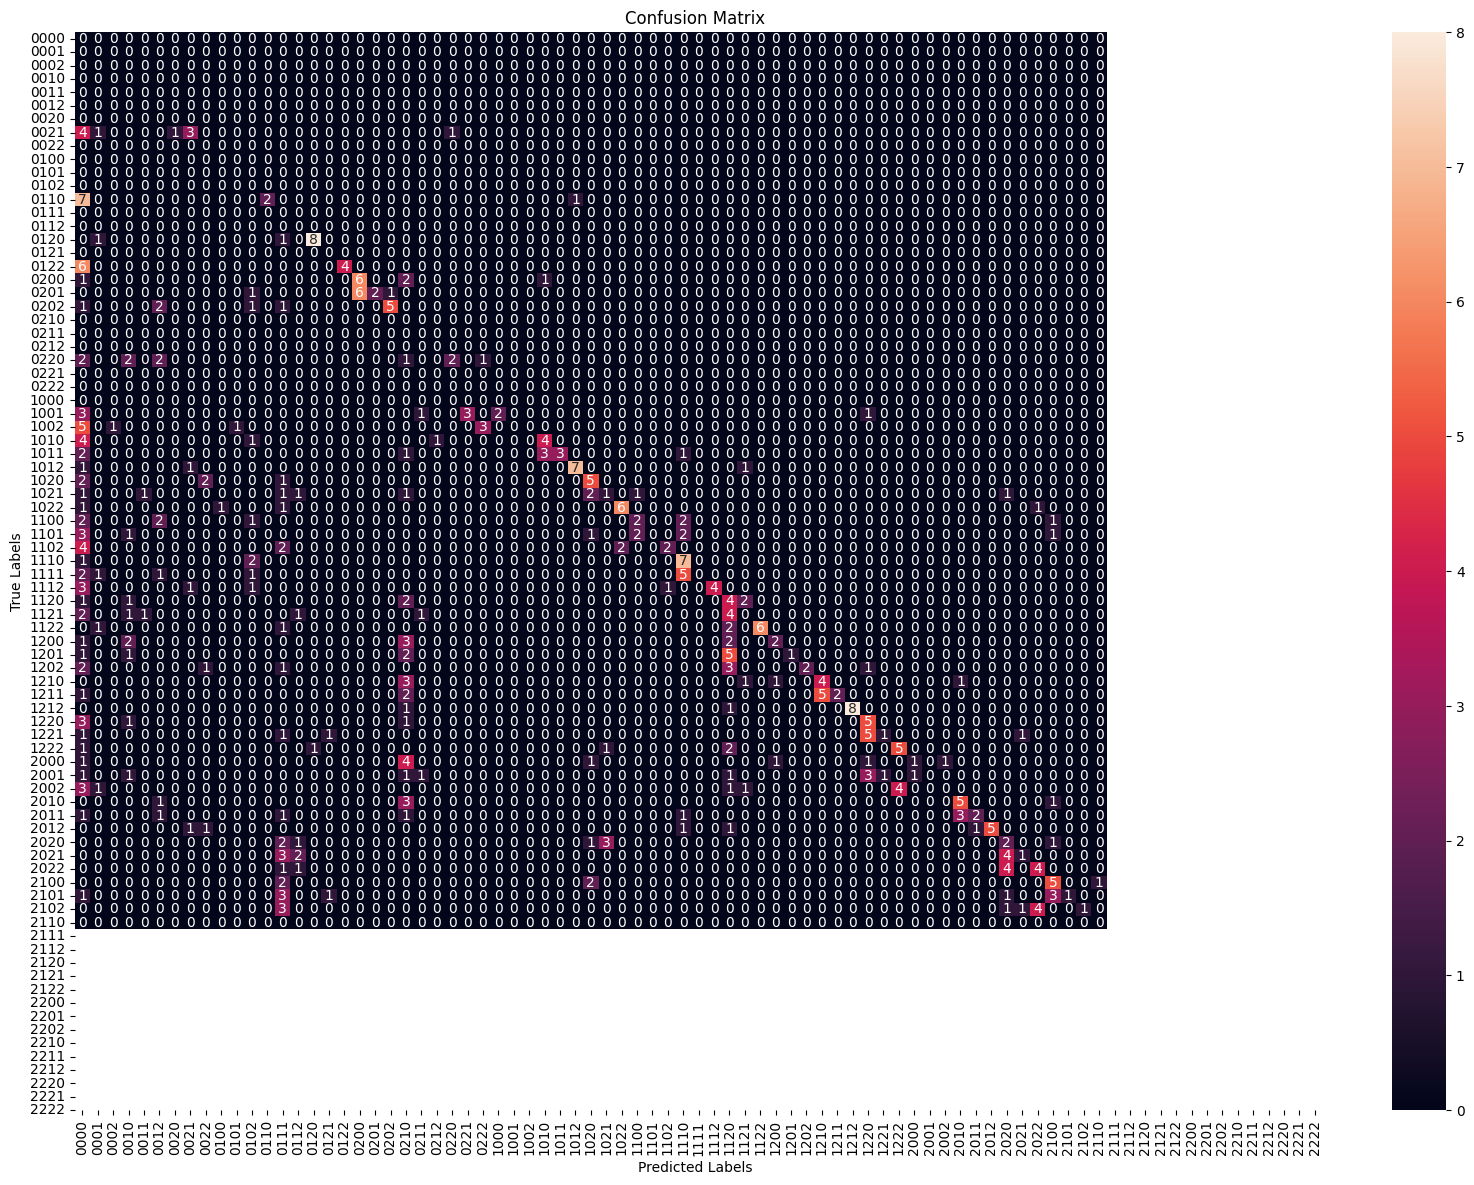

In [219]:
model_3D.eval()  # Set the model to evaluation mode
predicted_labels = []
with torch.no_grad():  # Disable gradient calculation
    for batch in test_loader_dots:
        inputs = batch[0].to(device)
        outputs = model_3D(inputs)
        _, predicted = torch.max(outputs, 1)
        predicted_labels.extend(predicted.cpu().numpy())
# Convert the list to a numpy array
predicted_labels = np.array(predicted_labels)
# If you need the result as a tensor, convert back to tensor
predicted_labels = torch.tensor(predicted_labels)
print(predicted_labels)

# _, predicted_labels = torch.max(model(X_test.to(device)), 1)
_, true_class_labels = torch.max(y_dots, 1)
print(true_class_labels)
predicted_labels_np = predicted_labels.cpu().numpy()
true_labels_np = true_class_labels.cpu().numpy()
cm = confusion_matrix(true_labels_np, predicted_labels_np)
plt.figure(figsize=(20, 14))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=knots, yticklabels=knots)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [220]:
Accuracy = (np.sum(predicted_labels_np == true_labels_np)) / len(predicted_labels_np)
print(Accuracy)

0.30434782608695654
